In [5]:
IN_FILE_PATH = "./data/gnews2.csv"
OUT_FILE_PATH = "./data/cluster/gnews_gmm.csv"
TEXT_COL = "summary"
N_CLUSTER = 5

In [6]:
"""
Clustering news articles with FinBERT embeddings + GMM
"""

# pip install pandas numpy scikit-learn scipy matplotlib seaborn transformers torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from transformers import AutoTokenizer, AutoModel
from numpy.linalg import inv, LinAlgError
from scipy.spatial.distance import mahalanobis
from sklearn.mixture import GaussianMixture
from typing import List, Optional, Tuple, Any
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from dataclasses import dataclass

# ------------------------
# FinBERT embeddings + GMM clustering
# ------------------------

@dataclass
class FinbertGMMConfig:
    model_name: str = "ProsusAI/finbert"
    max_tokens: int = 256
    batch_size: int = 16
    pca_components: int = 50
    n_components: int = 20   # GMM components (clusters)
    covariance_type: str = "full"
    random_state: int = 0


class FinbertEmbedder:
    def __init__(self, model_name: str, max_tokens: int = 256, device: Optional[str] = None):
        self.model_name = model_name
        self.max_tokens = max_tokens

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device

        self.model.to(self.device)
        self.model.eval()

    @torch.no_grad()
    def encode_batch(self, texts: List[str]) -> np.ndarray:
        """Encode a batch of texts into embeddings."""
        enc = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_tokens,
            return_tensors="pt"
        ).to(self.device)

        outputs = self.model(**enc)
        last_hidden = outputs.last_hidden_state  # (batch, seq_len, hidden)
        attention_mask = enc["attention_mask"].unsqueeze(-1)  # (batch, seq_len, 1)

        # masked mean pooling
        masked = last_hidden * attention_mask
        sum_embeddings = masked.sum(dim=1)  # (batch, hidden)
        lengths = attention_mask.sum(dim=1)  # (batch, 1)
        mean_embeddings = sum_embeddings / (lengths + 1e-9)

        return mean_embeddings.cpu().numpy()

    def encode_corpus(self, texts: List[str], batch_size: int = 16) -> np.ndarray:
        """Encode a full corpus with batching."""
        all_embs = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            embs = self.encode_batch(batch)
            all_embs.append(embs)
        return np.vstack(all_embs)


class FinbertGMMClustering:
    def __init__(self, config: FinbertGMMConfig):
        self.config = config
        self.embedder: Optional[FinbertEmbedder] = None
        self.pca: Optional[PCA] = None
        self.gmm: Optional[GaussianMixture] = None

    def fit(self, texts: List[str]) -> Tuple[np.ndarray, np.ndarray, GaussianMixture]:
        """
        Fit FinBERT embeddings + PCA + GMM on texts.
        Returns:
            cluster_ids: (N,) array of cluster labels
            Z: (N, p) PCA-reduced embeddings (for future use)
        """
        # 1) embeddings
        self.embedder = FinbertEmbedder(
            model_name=self.config.model_name,
            max_tokens=self.config.max_tokens
        )
        X_emb = self.embedder.encode_corpus(
            texts,
            batch_size=self.config.batch_size
        )
        print(f"[FinBERT] Embedded shape: {X_emb.shape}")

        # 2) PCA
        self.pca = PCA(n_components=self.config.pca_components, random_state=self.config.random_state)
        Z = self.pca.fit_transform(X_emb)
        print(f"[FinBERT] PCA-reduced shape: {Z.shape}")

        # 3) GMM
        self.gmm = GaussianMixture(
            n_components=self.config.n_components,
            covariance_type=self.config.covariance_type,
            random_state=self.config.random_state
        )
        self.gmm.fit(Z)
        cluster_ids = self.gmm.predict(Z)

        try:
            sil = silhouette_score(Z, cluster_ids, metric="euclidean")
            print(f"[FinBERT+GMM] Silhouette (euclidean): {sil:.3f}")
        except Exception as e:
            print(f"[FinBERT+GMM] Could not compute silhouette: {e}")

        return cluster_ids, Z, self.gmm

    def predict(self, new_texts: List[str]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Assign clusters to new texts.
        Returns:
            cluster_ids: (M,) labels
            probs: (M, K) cluster probabilities
        """
        if self.embedder is None or self.pca is None or self.gmm is None:
            raise RuntimeError("Model not fitted yet.")

        X_emb_new = self.embedder.encode_corpus(new_texts, batch_size=self.config.batch_size)
        Z_new = self.pca.transform(X_emb_new)
        cluster_ids = self.gmm.predict(Z_new)
        probs = self.gmm.predict_proba(Z_new)
        return cluster_ids, probs




In [7]:

# ------------------------
# Utilities
# ------------------------

def basic_clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # strip whitespace, collapse spaces; keep case/nums because they are informative
    text = text.strip()
    text = " ".join(text.split())
    return text

def load_texts_from_csv(path: str = IN_FILE_PATH, text_column: str = TEXT_COL) -> List[str]:
    df = pd.read_csv(path)
    df_cleaned = df.dropna(subset=['summary'])
    df_cleaned = df_cleaned[~df_cleaned['summary'].str.startswith('I am unable')]
    df_cleaned = df_cleaned[~df_cleaned['summary'].str.startswith('The article at')]
    df_cleaned = df_cleaned[~df_cleaned['summary'].str.startswith('Apple')]
    df_cleaned = df_cleaned.reset_index(drop=True)


    if text_column not in df_cleaned.columns:
        raise ValueError(f"Column '{text_column}' not found in CSV.")
    texts = [basic_clean(t) for t in df_cleaned[text_column].astype(str).tolist()]
    return texts, df_cleaned

def create_visualization(Z_data: np.ndarray, df: pd.DataFrame):
    """
    Runs PCA on the existing 20-component data (Z) to get a 2D projection
    for visualization, then creates a scatter plot colored by GMM cluster ID.
    """
    # 1. Run PCA to reduce the data from 20 dimensions (Z) down to 2 dimensions (2D)
    # uses the data already processed by the FinBERT pipeline.
    pca_plot = PCA(n_components=2, random_state=0)
    Z_pca_2d = pca_plot.fit_transform(Z_data)

    # 2. Add the 2D coordinates to the DataFrame
    df['pca_x'] = Z_pca_2d[:, 0]
    df['pca_y'] = Z_pca_2d[:, 1]

    # 3. Create Visualization
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='pca_x',
        y='pca_y',
        hue='cluster_finbert_gmm', # Use the FinBERT cluster ID for color
        palette='tab10',
        data=df,
        legend='full',
        s=70,
        alpha=0.7
    )

    plt.title('2D PCA Visualization of FinBERT GMM Clusters', fontsize=14)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc=2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def get_frequent_words_per_cluster(df, text_col, cluster_col, n_top_words=10):
    clusters = sorted(df[cluster_col].unique())
    vectorizer = CountVectorizer(stop_words='english')

    print(f"=== Frequent Words per Cluster (Top {n_top_words}) ===\n")

    for cluster in clusters:
        subset = df[df[cluster_col] == cluster]
        texts = subset[text_col].astype(str).tolist()

        if not texts:
            print(f"Cluster {cluster}: No data.")
            continue

        try:
            X = vectorizer.fit_transform(texts)
            word_counts = np.array(X.sum(axis=0)).flatten()
            features = np.array(vectorizer.get_feature_names_out())

            top_indices = word_counts.argsort()[::-1][:n_top_words]
            top_words = features[top_indices]

            print(f"Cluster {cluster} ({len(texts)} articles):")
            print(f"  {', '.join(top_words)}")
            print("-" * 50)

        except ValueError:
            # This happens if the texts contain only stop words or are empty
            print(f"Cluster {cluster}: Could not extract words (possibly empty).")
            print("-" * 50)

Loaded 280 articles.

=== FinBERT + GMM ===
[FinBERT] Embedded shape: (280, 768)
[FinBERT] PCA-reduced shape: (280, 10)
[FinBERT+GMM] Silhouette (euclidean): 0.174


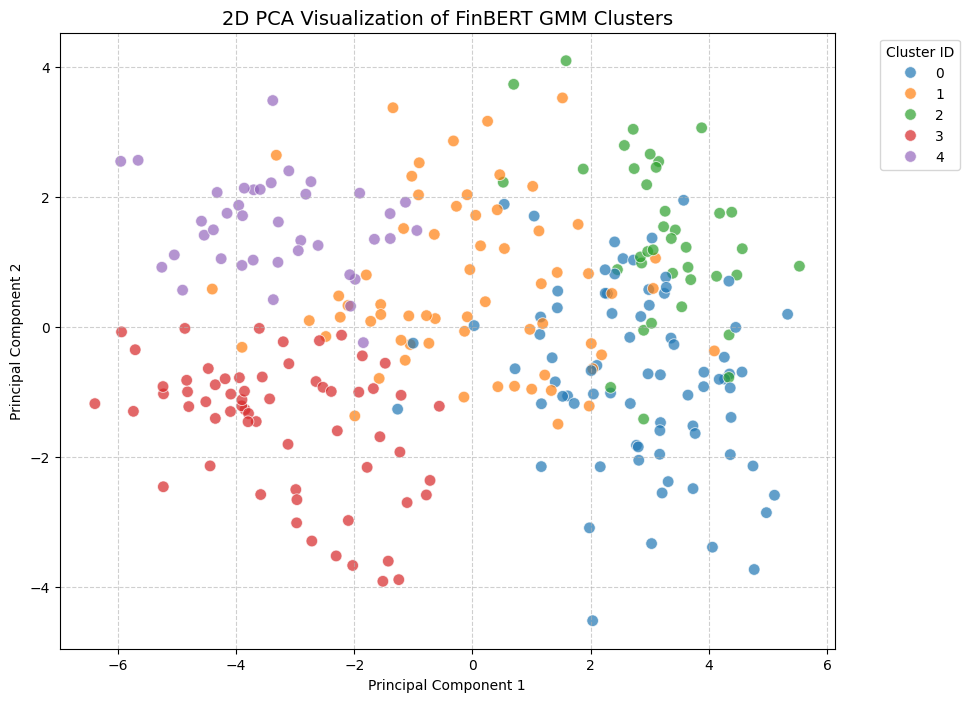

=== Frequent Words per Cluster (Top 10) ===

Cluster 0 (77 articles):
  new, energy, discusses, challenges, article, digital, sustainable, significant, industry, piece
--------------------------------------------------
Cluster 1 (64 articles):
  new, report, international, health, global, economic, public, australia, efforts, article
--------------------------------------------------
Cluster 2 (38 articles):
  new, article, community, potential, significant, life, local, understanding, space, scientific
--------------------------------------------------
Cluster 3 (62 articles):
  economic, inflation, article, economy, reserve, persistent, federal, rate, growth, market
--------------------------------------------------
Cluster 4 (39 articles):
  abortion, state, new, access, federal, significant, international, ruling, court, legal
--------------------------------------------------

Successfully saved clustered data to: ./data/cluster/gnews_gmm.csv


In [8]:
def main():
    texts, df = load_texts_from_csv(IN_FILE_PATH, text_column=TEXT_COL)
    print(f"Loaded {len(texts)} articles.")

    # -------------------------------------
    # Cluster
    # -------------------------------------
    print("\n=== FinBERT + GMM ===")
    finbert_cfg = FinbertGMMConfig(
        model_name="ProsusAI/finbert",
        max_tokens=256,
        batch_size=8,
        pca_components=N_CLUSTER*2,
        n_components=N_CLUSTER,
        covariance_type="full",
        random_state=0
    )
    finbert_model = FinbertGMMClustering(finbert_cfg)
    finbert_clusters, Z, gmm_sim = finbert_model.fit(texts)
    df["cluster_finbert_gmm"] = finbert_clusters

    # -------------------------------------
    # Visualization
    # -------------------------------------
    create_visualization(Z, df)

    # -------------------------------------
    # Peek at top words
    # -------------------------------------
    get_frequent_words_per_cluster(df, TEXT_COL, "cluster_finbert_gmm")

    # -------------------------------------
    # Save results
    # -------------------------------------
    try:
        os.makedirs(os.path.dirname(OUT_FILE_PATH), exist_ok=True)
        df.to_csv(OUT_FILE_PATH, index=False)
        print(f"\nSuccessfully saved clustered data to: {OUT_FILE_PATH}")
    except Exception as e:
        print(f"\nError saving file to {OUT_FILE_PATH}: {e}")


if __name__ == "__main__":
    main()